In [1]:
import sys, os
import pandas as pd
import numpy as np

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
import matplotlib.pyplot as plt

from skimage import io
from keras.preprocessing import image
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator

In [2]:
df=pd.read_csv('fer2013.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35340 entries, 0 to 35339
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35340 non-null  int64 
 1   pixels   35340 non-null  object
 2   Usage    35340 non-null  object
dtypes: int64(1), object(2)
memory usage: 828.4+ KB
None


In [4]:
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            0  30 24 21 23 25 25 49 67 84 103 120 125 130 139...     Training
3            0  123 125 124 142 209 226 234 236 231 232 235 22...     Training
4            0  8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...     Training
...        ...                                                ...          ...
35335        5  87 82 59 61 72 102 143 130 90 95 143 173 146 1...  PrivateTest
35336        5  112 102 98 89 98 133 164 185 180 179 185 169 1...  PrivateTest
35337        5  29 29 27 31 49 56 29 19 22 20 34 43 55 71 85 9...  PrivateTest
35338        5  139 143 145 154 159 168 176 181 190 191 195 19...  PrivateTest
35339        5  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest

[35340 rows x 3 columns]


In [5]:
print(df.head())
print(df.columns)

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        0  30 24 21 23 25 25 49 67 84 103 120 125 130 139...  Training
3        0  123 125 124 142 209 226 234 236 231 232 235 22...  Training
4        0  8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...  Training
Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [6]:
print(df["Usage"].value_counts())


Training       28273
PrivateTest     3534
PublicTest      3533
Name: Usage, dtype: int64


<AxesSubplot:>

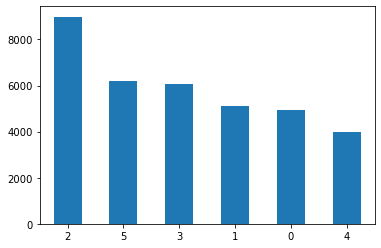

In [7]:
df['emotion'].value_counts().plot.bar(rot=0)

In [8]:
emotions = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [9]:
X_train,train_y,X_test,test_y=[],[],[],[]


In [10]:
for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    if 'Training' in row['Usage']:
        X_train.append(np.array(val,'float32'))
        train_y.append(row['emotion'])
    elif 'PublicTest' in row['Usage']:
        X_test.append(np.array(val,'float32'))
        test_y.append(row['emotion'])
        

In [11]:
num_features = 64
num_labels = 6
batch_size = 256
epochs = 80
width, height = 48, 48

In [12]:
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

In [13]:
print(X_train.shape)
print(X_test.shape)

(28273, 2304)
(3533, 2304)


In [14]:
oversample = RandomOverSampler(sampling_strategy='auto')

X_train, train_y = oversample.fit_resample(X_train.reshape(X_train.shape[0],48*48), train_y)

print(X_train.shape)


(43290, 2304)


In [15]:
X_train = np.array(X_train, 'float32')
train_y = np.array(train_y, 'float32')

X_test = np.array(X_test, 'float32')
test_y = np.array(test_y, 'float32')


X_train = X_train/255
X_test = X_test/255

In [16]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = X_train.astype('float32')

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = X_test.astype('float32')

In [17]:
train_y=np_utils.to_categorical(train_y)
test_y=np_utils.to_categorical(test_y)

In [18]:
print(f"shape:{X_train.shape}")
print(f"shape:{X_test.shape}")

shape:(43290, 48, 48, 1)
shape:(3533, 48, 48, 1)


In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(32, kernel_size=3, activation='relu', padding = 'same', input_shape=(X_train.shape[1:])))
#kernel (3,3)
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size= 3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#stride = (2,2)
model.add(Dropout(0.2))

In [21]:
model.add(Conv2D(64, 3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

In [22]:
model.add(Conv2D(128, 3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

In [23]:
model.add(Flatten())

In [24]:
model.add(Dense(128, activation='relu'))

In [25]:
model.add(Dense(num_labels, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

In [27]:
dgen = ImageDataGenerator(validation_split = 0.2, rotation_range=10, horizontal_flip=True)
train_data = dgen.flow(X_train, train_y, batch_size=batch_size, subset='training', shuffle=True)
val_data = dgen.flow(X_test, test_y, batch_size=batch_size, subset='validation', shuffle=True)

In [28]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.7, min_delta=1e-7)
# factor = 0.5

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [30]:
model.fit(train_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_data,
          callbacks=[es, reduce_lr],
          shuffle=True)

Epoch 1/80
136/136 [==============================] - 97s 411ms/step - loss: 1.7766 - accuracy: 0.3354 - val_loss: 2.1908 - val_accuracy: 0.0000e+00
Epoch 2/80
136/136 [==============================] - 51s 376ms/step - loss: 1.3897 - accuracy: 0.4631 - val_loss: 2.3284 - val_accuracy: 0.0000e+00
Epoch 3/80
136/136 [==============================] - 51s 378ms/step - loss: 1.2576 - accuracy: 0.5167 - val_loss: 2.6630 - val_accuracy: 0.0000e+00
Epoch 4/80
136/136 [==============================] - 52s 377ms/step - loss: 1.1647 - accuracy: 0.5615 - val_loss: 2.0885 - val_accuracy: 0.0892
Epoch 5/80
136/136 [==============================] - 52s 378ms/step - loss: 1.1048 - accuracy: 0.5845 - val_loss: 2.5854 - val_accuracy: 0.0368
Epoch 6/80
136/136 [==============================] - 53s 384ms/step - loss: 1.0555 - accuracy: 0.6048 - val_loss: 2.0732 - val_accuracy: 0.1884
Epoch 7/80
136/136 [==============================] - 52s 379ms/step - loss: 1.0157 - accuracy: 0.6201 - val_loss: 2.4

In [31]:
emotions = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [32]:
def emotion_analysis(emotions):
    objects = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


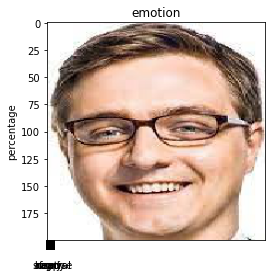

Actual emotion: Happy
Prediction emotion:  Happy


In [33]:
img = image.load_img('happy1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('happy1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()

print("Actual emotion: Happy" )
print("Prediction emotion: ", emotions[np.argmax(custom)])

In [118]:
print(custom[0])

[3.0252931e-04 2.4684461e-05 9.9653673e-01 2.3171880e-05 6.8800506e-04
 2.4249672e-03]


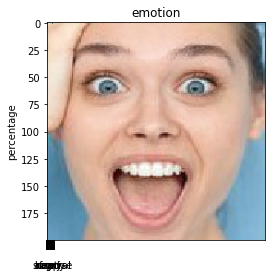

Actual emotion: Surprise
Prediction emotion:  Surprise


In [35]:
img = image.load_img('Surprise1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Surprise1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()
print("Actual emotion: Surprise" )
print("Prediction emotion: ", emotions[np.argmax(custom)])
# print('Expression Prediction:',objects[ind])

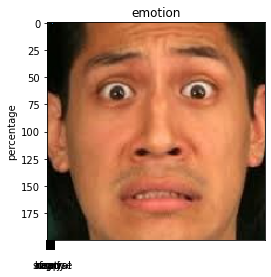

Actual emotion: Fear
Prediction emotion:  Surprise


In [36]:
img = image.load_img('fear1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('fear1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()
print("Actual emotion: Fear" )
print("Prediction emotion: ", emotions[np.argmax(custom)])



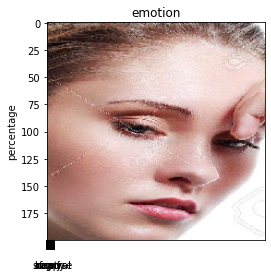

Actual emotion: Sad
Prediction emotion:  Sad


In [37]:
img = image.load_img('sad1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('sad1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()
print("Actual emotion: Sad" )
print("Prediction emotion: ", emotions[np.argmax(custom)])

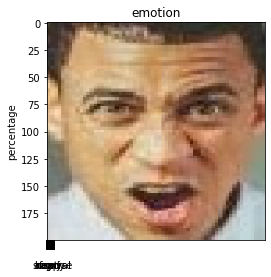

Actual emotion: Angry
Prediction emotion:  Surprise


In [38]:
img = image.load_img('anger1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('anger1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()
print("Actual emotion: Angry" )
print("Prediction emotion: ", emotions[np.argmax(custom)])

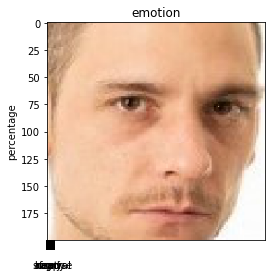

Actual emotion: Fear
Prediction emotion:  Neutral


In [40]:
img = image.load_img('neutral1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('neutral1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

plt.imshow(show_img)
plt.show()
print("Actual emotion: Fear" )
print("Prediction emotion: ", emotions[np.argmax(custom)])

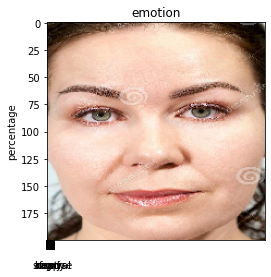

In [130]:
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

In [128]:
img = image.load_img('angry1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('angry1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)


m=0.0000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
objects = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print('Expression Prediction:',objects[ind])

Expression Prediction: angry


In [129]:
img = image.load_img('neut1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('neut1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)


m=0.0000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
objects = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print('Expression Prediction:',objects[ind])

Expression Prediction: neutral


In [2]:
img = image.load_img('feary1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('feary1.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)


m=0.0000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
objects = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print('Expression Prediction:',objects[ind])

NameError: name 'image' is not defined

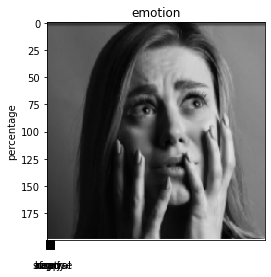

In [146]:
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

In [147]:
fer_json = model.to_json()
with open("FER.json", "w") as json_file:
    json_file.write(fer_json)
model.save("fer.h5")